# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2022spring-ta@googlegroups.com

Slide:    [Link]()　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw8)

# Set up the environment


## Package installation

# Import packages

In [1]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
from torch.optim import Adam, AdamW
from qqdm import qqdm, format_str
import pandas as pd
from torchvision.transforms.functional import crop

# Loading data

In [2]:

train = np.load('data/trainingset.npy', allow_pickle=True)
test = np.load('data/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [3]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(48763)

# Autoencoder

# Models & loss

In [4]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64 * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 24),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(24, 512),
            nn.ReLU(), 
            nn.Linear(512, 64 * 64 * 3), 
            nn.Tanh()
        )

    def forward(self, x):
        # print(x.shape)
        # raise
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),        
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),         
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [5]:
class CustomTensorDataset(TensorDataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        
        self.transform = transforms.Compose([
          transforms.Lambda(lambda x: x.to(torch.float32)),
          transforms.Lambda(lambda x: crop(x,10,0,28,64)),
          transforms.Resize((64,64)),
          transforms.Lambda(lambda x: 2. * x/255. - 1.),
        ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)
        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [6]:
# Training hyperparameters
num_epochs = 200
batch_size = 32
learning_rate = 1e-3

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x)

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

# Model
model_type = 'fcn'   # selecting a model type from {'cnn', 'fcn', 'vae', 'resnet'}
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE()}
model = model_classes[model_type].cuda()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)

In [7]:
# # ref:https://keestalkstech.com/2020/05/plotting-a-grid-of-pil-images-in-jupyter/
import matplotlib.pyplot as plt
from PIL import Image

def display_images(images, loss):
    fig = plt.figure(figsize=(10, 10))
    columns = 5
    rows = 5
    for i, img in enumerate(images):
        ax = fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
        x = i // columns
        y = i % columns
        ax.set_title(f"loss:  {loss[i]:.4f}")

    plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)

    plt.show()

# model = torch.load("last_model_cnn.pt")

def disimg(model,s=0,e=25):
  model.eval()
  original, reconstruct= [], []
  original_loss, reconstruct_loss = [],[]
  eval_loss = nn.MSELoss(reduction='none')
  with torch.no_grad():
    for i in range(s,e):
      np_array = test[i]
      pil_image= Image.fromarray(np_array)
      original.append(pil_image)

      tf = transforms.Compose([
                transforms.Lambda(lambda x: x.to(torch.float32)),
                transforms.Lambda(lambda x: crop(x,10,0,28,64)),
                transforms.Resize((64,64)),
                transforms.Lambda(lambda x: 2. * x/255. - 1.),
              ])

      tf2 = transforms.Compose([
                transforms.Lambda(lambda x: 255. * (x + 1.) / 2.),
              ])
      # print(tf(torch.tensor(train[0])).size())
      data = torch.tensor(np_array).permute(2,0,1).unsqueeze(0).cuda()
      # print(data.size())
      data = tf(data).reshape(-1,64*64*3)
      out_array = model(data)
      # loss = eval_loss(out_array, tf(data)).cuda().item()
      loss = eval_loss(out_array, data).sum(-1).item()
      original_loss.append(loss)
      reconstruct_loss.append(loss)
      # print(out_array)
      out_array = out_array.reshape(-1,3,64,64)
      out_array = tf2(out_array[0])
      out_array = out_array.squeeze(0).permute(1,2,0).cpu().detach().numpy()
      pil_image_out= Image.fromarray(np.uint8(out_array))
      reconstruct.append(pil_image_out)

  display_images(original, original_loss)
  display_images(reconstruct, reconstruct_loss)

## Training loop

1/200 | loss: 0.0518


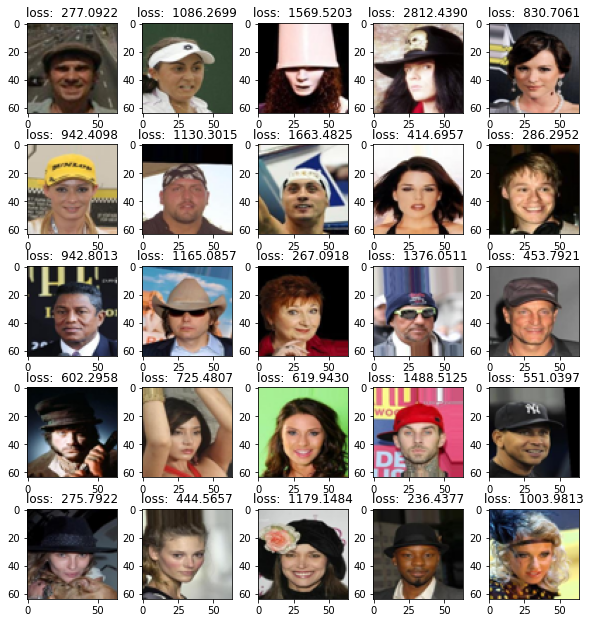

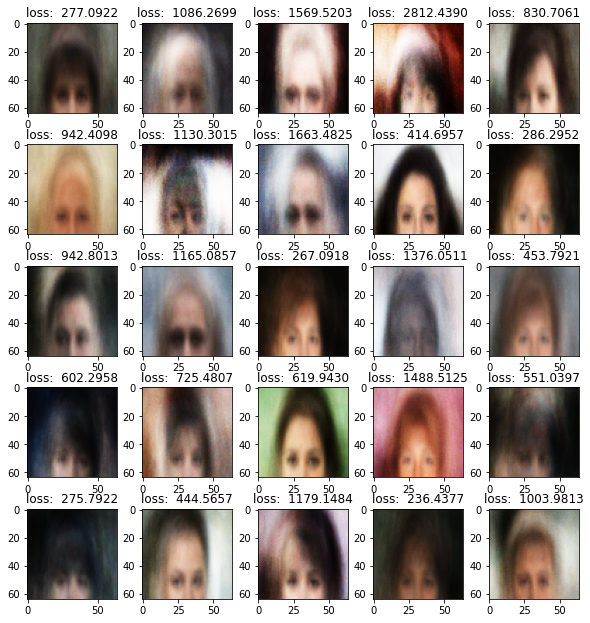

2/200 | loss: 0.0412
3/200 | loss: 0.0395
4/200 | loss: 0.0389
5/200 | loss: 0.0385
6/200 | loss: 0.0380
7/200 | loss: 0.0377
8/200 | loss: 0.0374
9/200 | loss: 0.0373
10/200 | loss: 0.0371
11/200 | loss: 0.0370


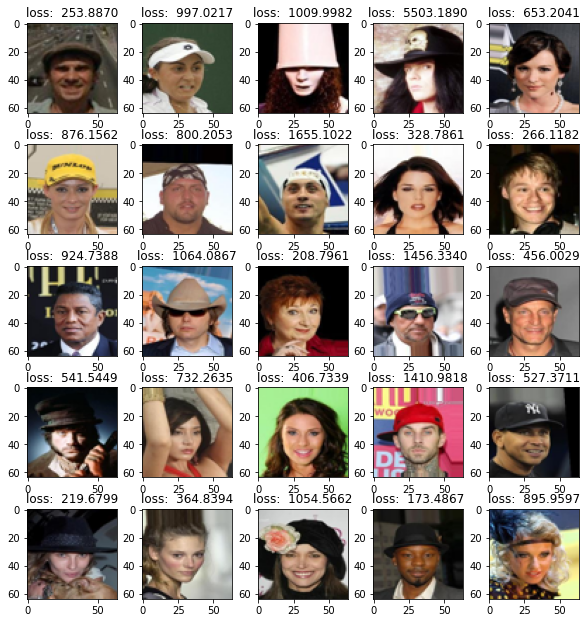

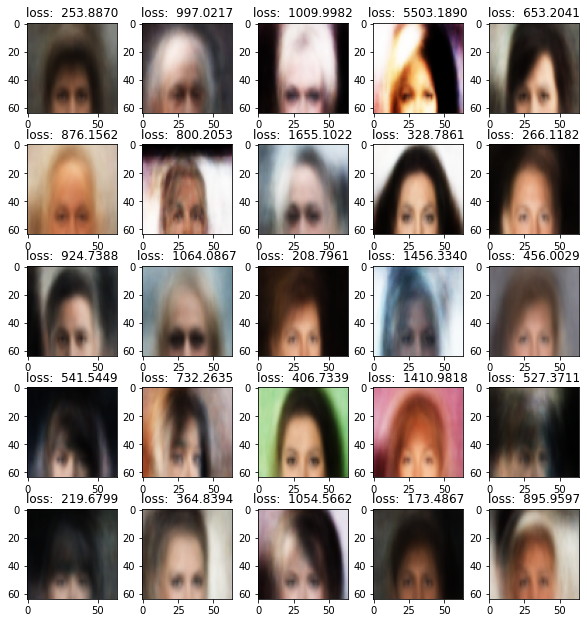

12/200 | loss: 0.0368
13/200 | loss: 0.0366
not improved: 14/200 | loss: 0.0367
15/200 | loss: 0.0366
16/200 | loss: 0.0364
not improved: 17/200 | loss: 0.0365
18/200 | loss: 0.0363
not improved: 19/200 | loss: 0.0363
not improved: 20/200 | loss: 0.0363
21/200 | loss: 0.0361


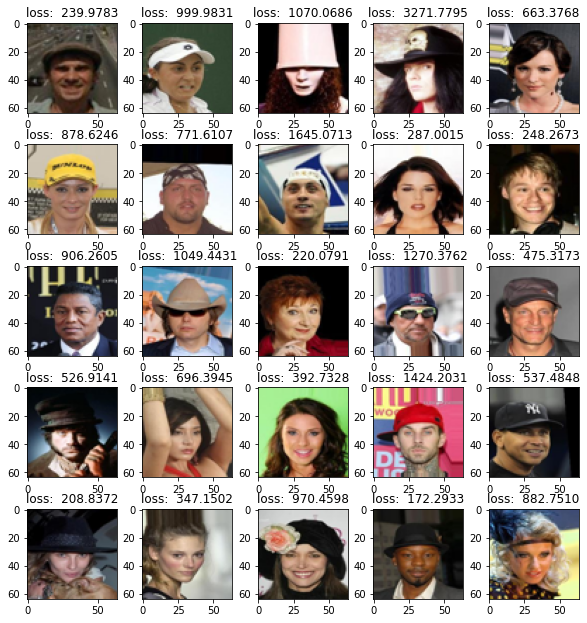

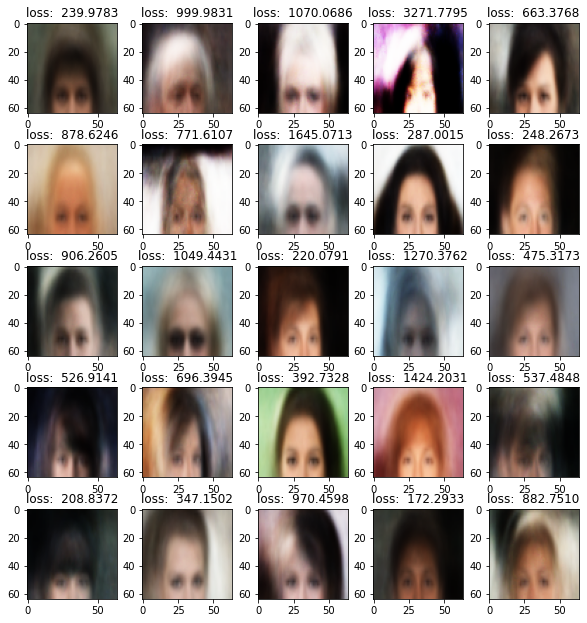

not improved: 22/200 | loss: 0.0362
23/200 | loss: 0.0361
24/200 | loss: 0.0360
25/200 | loss: 0.0360
not improved: 26/200 | loss: 0.0361
27/200 | loss: 0.0360
not improved: 28/200 | loss: 0.0361
not improved: 29/200 | loss: 0.0360
not improved: 30/200 | loss: 0.0360
31/200 | loss: 0.0359


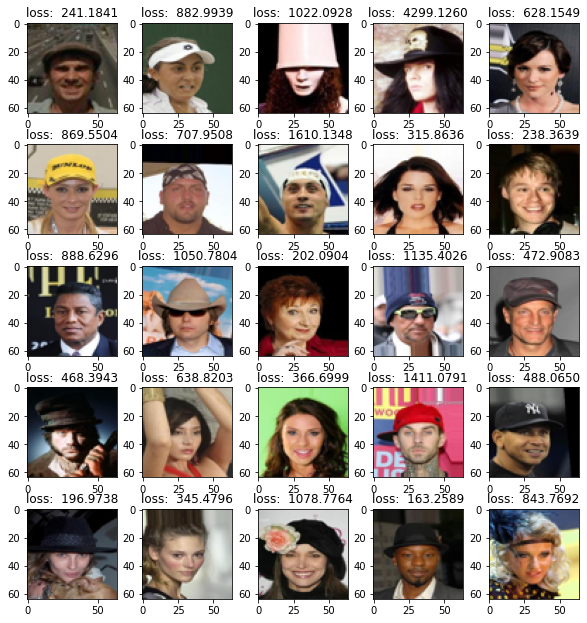

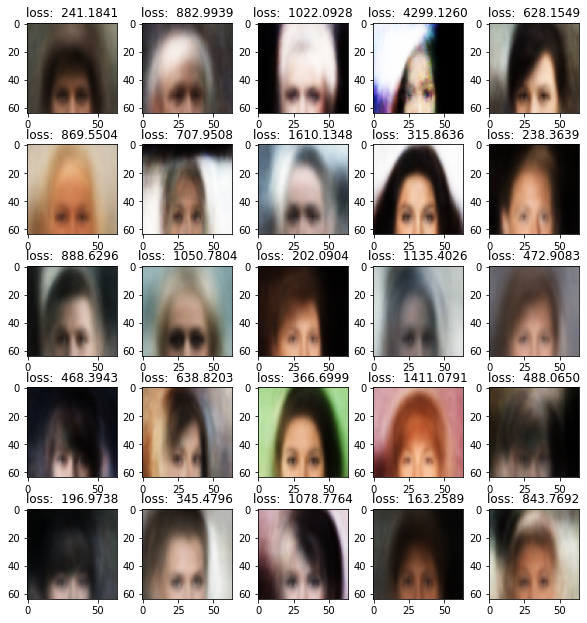

not improved: 32/200 | loss: 0.0359
33/200 | loss: 0.0358
34/200 | loss: 0.0358
not improved: 35/200 | loss: 0.0359
not improved: 36/200 | loss: 0.0359
not improved: 37/200 | loss: 0.0359
not improved: 38/200 | loss: 0.0359
not improved: 39/200 | loss: 0.0358
40/200 | loss: 0.0357
not improved: 41/200 | loss: 0.0358


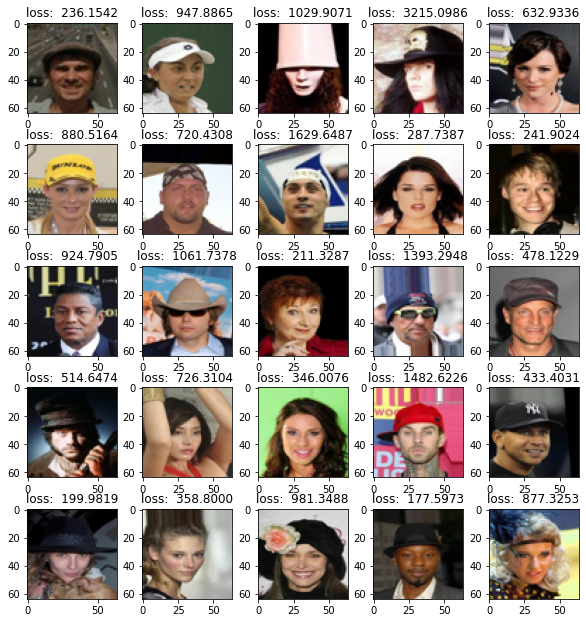

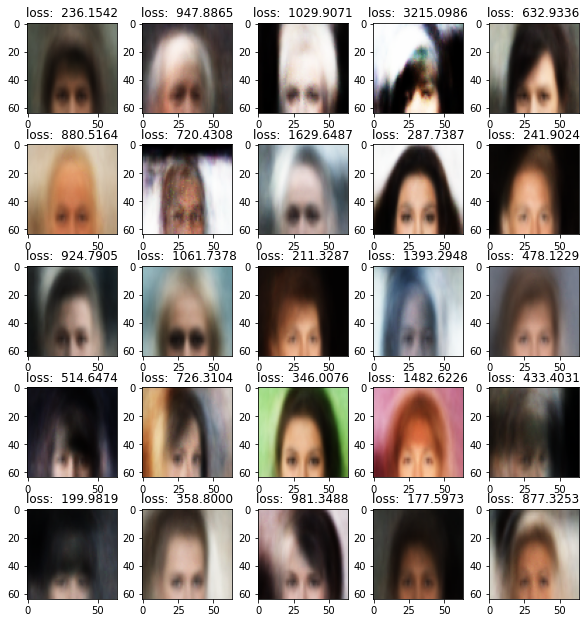

not improved: 42/200 | loss: 0.0358
not improved: 43/200 | loss: 0.0357
not improved: 44/200 | loss: 0.0357
not improved: 45/200 | loss: 0.0357


KeyboardInterrupt: 

In [8]:
PATH = 'fcn_6.pt'
# model = torch.load(PATH)
best_loss = np.inf
model.train()

for epoch in range(num_epochs):
    tot_loss = list()
    for data in train_dataloader:

        # ===================loading=====================
        img = data.float().cuda()
        if model_type in ['fcn']:
            img = img.view(img.shape[0], -1)

        # ===================forward=====================
        output = model(img)
        if model_type in ['vae']:
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            loss = criterion(output, img)

        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, PATH)
        print(f'{epoch + 1:.0f}/{num_epochs:.0f} | loss: {mean_loss:.4f}')
    else:
        print(f'not improved: {epoch + 1:.0f}/{num_epochs:.0f} | loss: {mean_loss:.4f}')

    if epoch % 10 == 0:
        disimg(model)


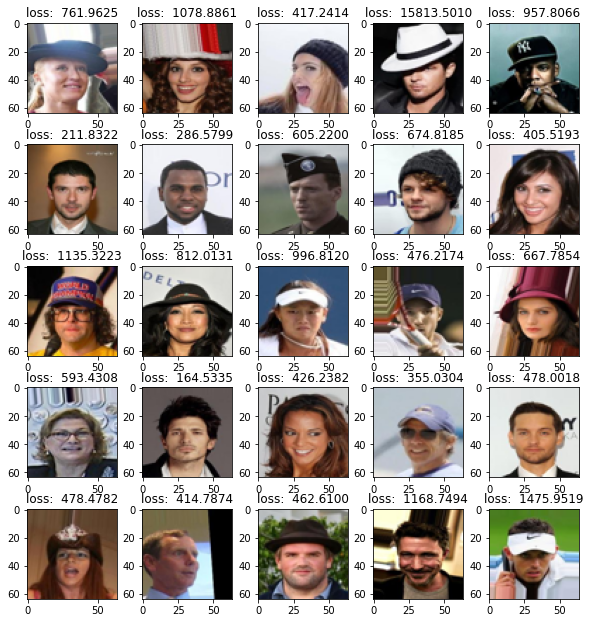

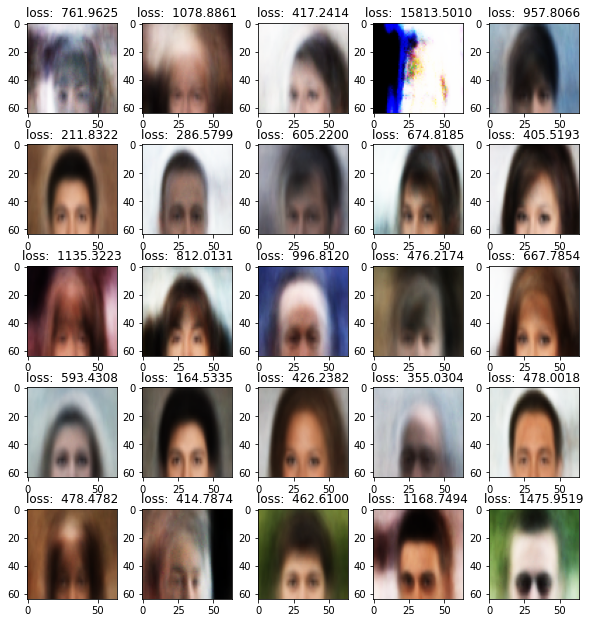

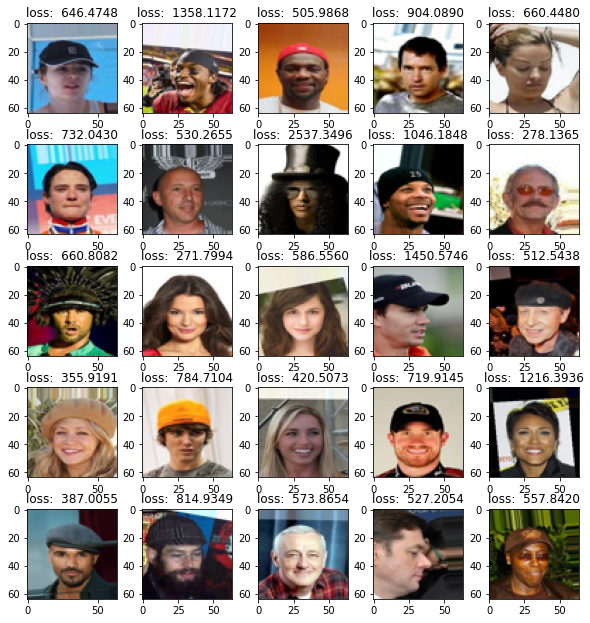

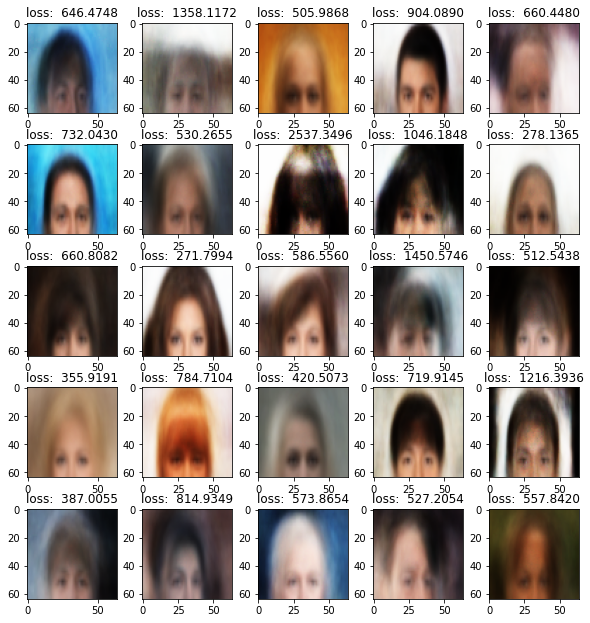

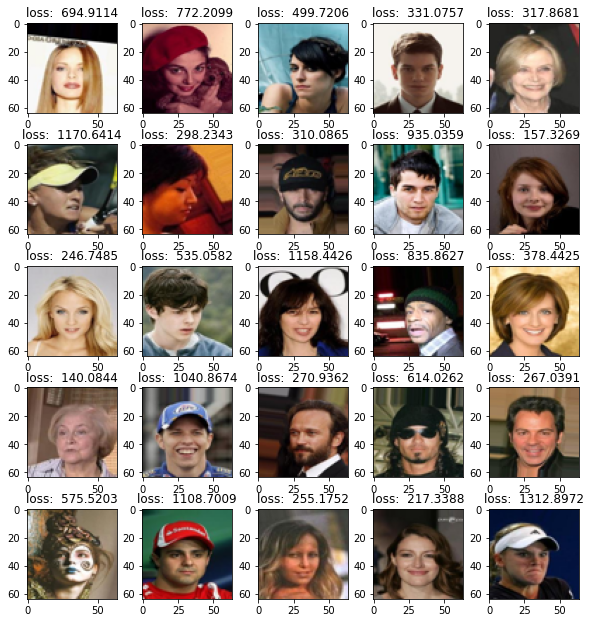

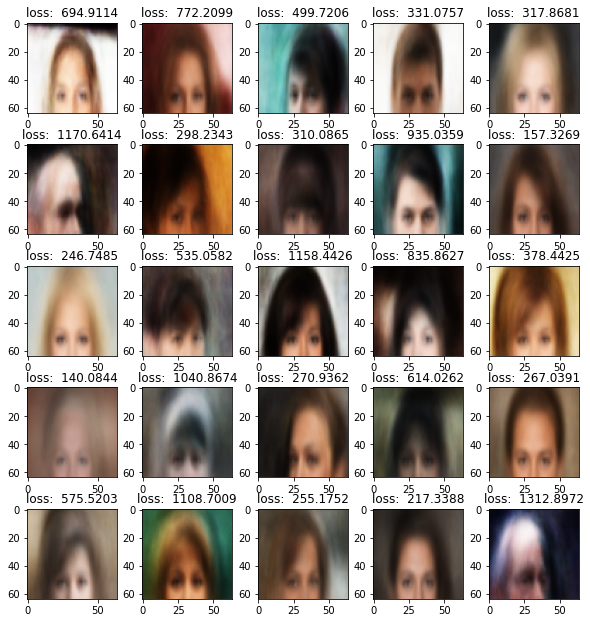

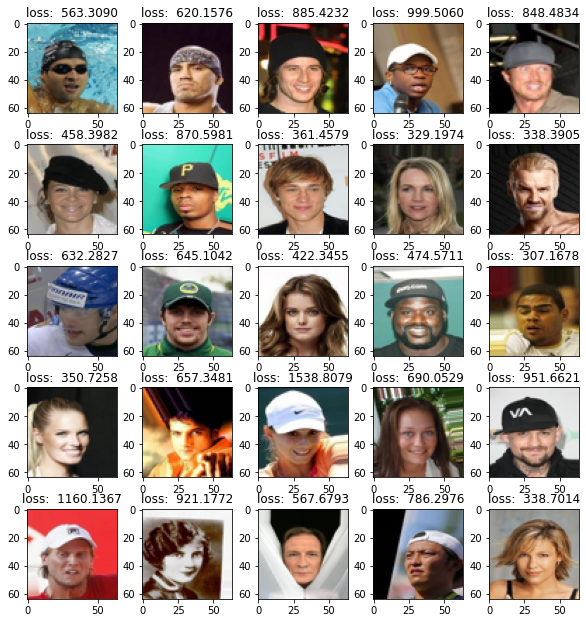

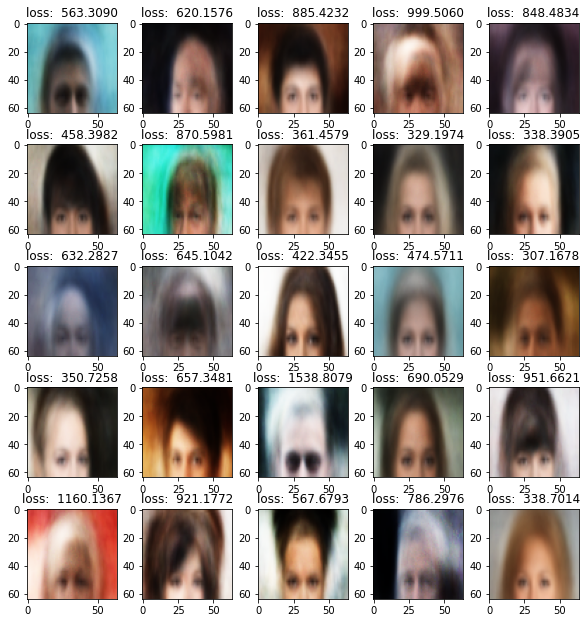

In [9]:
for i in range(200,300,25):
    disimg(model, i, i+25)

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [ ]:
eval_batch_size = 200

# build testing dataloader
data = torch.tensor(test, dtype=torch.float32)
test_dataset = CustomTensorDataset(data)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=1)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = PATH
model = torch.load(checkpoint_path)
model.eval()

# prediction file 
out_file = 'prediction_fcn6.csv'

In [ ]:
anomality = list()
with torch.no_grad():
  for i, data in enumerate(test_dataloader):
    img = data.float().cuda()
    if model_type in ['fcn']:
      img = img.view(img.shape[0], -1)
    output = model(img)
    if model_type in ['vae']:
      output = output[0]
    if model_type in ['fcn']:
        loss = eval_loss(output, img).sum(-1)
    else:
        loss = eval_loss(output, img).sum([1, 2, 3])
    anomality.append(loss)
anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')